In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils.data import get_hsm_dataset, get_solar_energy_dataset, get_fuel_prices_dataset, get_passengers_dataset, log_returns, inverse_log_returns, get_dataset_iterator
from utils.visualization import visualization

In [2]:
hsm_dataset_dir = Path("data/huge_stock_market_dataset/")
se_dataset_dir = Path("data/solar_energy/")
fp_dataset_dir = Path("data/fuel_prices/")
ap_dataset_dir = Path("data/air_passengers/")
results_dir = Path("results")

In [3]:
hsm_info = pd.read_csv(hsm_dataset_dir / "selected100.csv")
hsm_info["ts_id"] = hsm_info.index

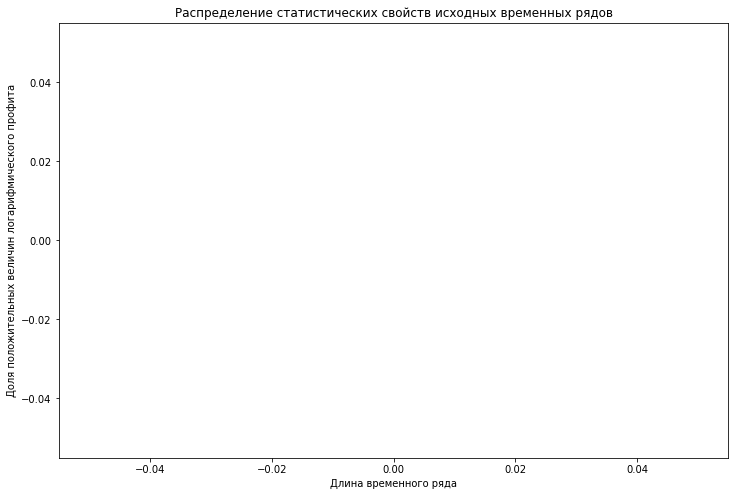

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(hsm_info["length"], y=hsm_info["uptrending_rate"], ax=ax)
ax.set_xlabel("Длина временного ряда")
ax.set_ylabel("Доля положительных величин логарифмического профита")
ax.set_title("Распределение статистических свойств исходных временных рядов")
plt.show()

In [5]:
results = []
for results_type in ("real", "QuantGAN", "TTS_GAN", "RealNVP", "FourierFlow", "TimeDiffusion"):
    for model in ("LSTM", "TCN"):#, "CBR"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            if results_type == "real":
                df = pd.read_csv(results_dir / f"{results_type}_{dataset_name}_{model}.csv")
            else:
                df = pd.read_csv(results_dir / f"synth_{results_type}_{dataset_name}_{model}.csv")
            df["model"] = model
            df["results_type"] = results_type
            df["dataset"] = dataset_name
            results.append(df)
results = pd.concat(results)
# results["model"].replace("CBR", "CatBoostRegressor", inplace=True)
# results["results_type"].replace(["pure", "QuantGAN_synth", "FourierFlow_synth", "RealNVP_synth", "TTS_GAN_synth"],
#                                 ["train set", "QuantGAN synthetic data", "FourierFlow synthetic data", "RealNVP synthetic data", "TTS GAN synthetic data"], 
#                                 inplace=True)
results

,test,model,results_type,dataset
0,0.352968,LSTM,real,hsm
1,0.168099,LSTM,real,hsm
2,1.425858,LSTM,real,hsm
3,0.139445,LSTM,real,hsm
4,0.283939,LSTM,real,hsm
...,...,...,...,...
45,0.690134,TCN,TimeDiffusion,ap
46,0.614346,TCN,TimeDiffusion,ap
47,1.052645,TCN,TimeDiffusion,ap
48,2.455103,TCN,TimeDiffusion,ap


In [6]:
results_agg = results.groupby(by=["model", "results_type", "dataset"], axis=0, as_index=False).agg(test=("test", "mean"))
results_agg

,model,results_type,dataset,test
0,LSTM,FourierFlow,ap,0.916432
1,LSTM,FourierFlow,fp,0.384317
2,LSTM,FourierFlow,hsm,0.437786
3,LSTM,FourierFlow,se,0.257221
4,LSTM,QuantGAN,ap,0.843753
5,LSTM,QuantGAN,fp,0.900859
6,LSTM,QuantGAN,hsm,0.876942
7,LSTM,QuantGAN,se,0.620816
8,LSTM,RealNVP,ap,6.138466
9,LSTM,RealNVP,fp,0.624790


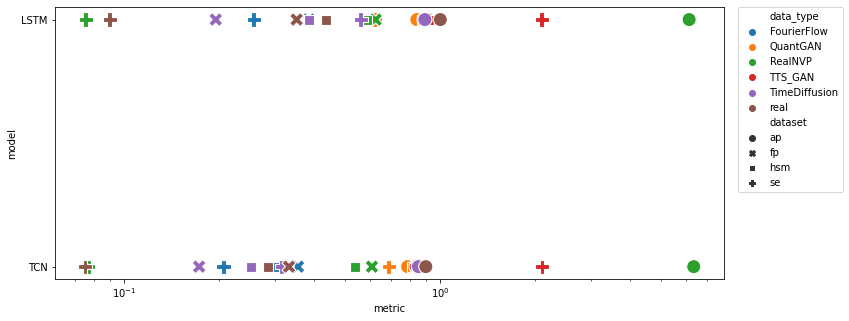

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.scatterplot(x=results_agg["test"].rename("metric"), y=results_agg["model"], 
    hue=results_agg["results_type"].rename("data_type"), style=results_agg["dataset"], s=200, ax=ax)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xscale("log")
plt.show()

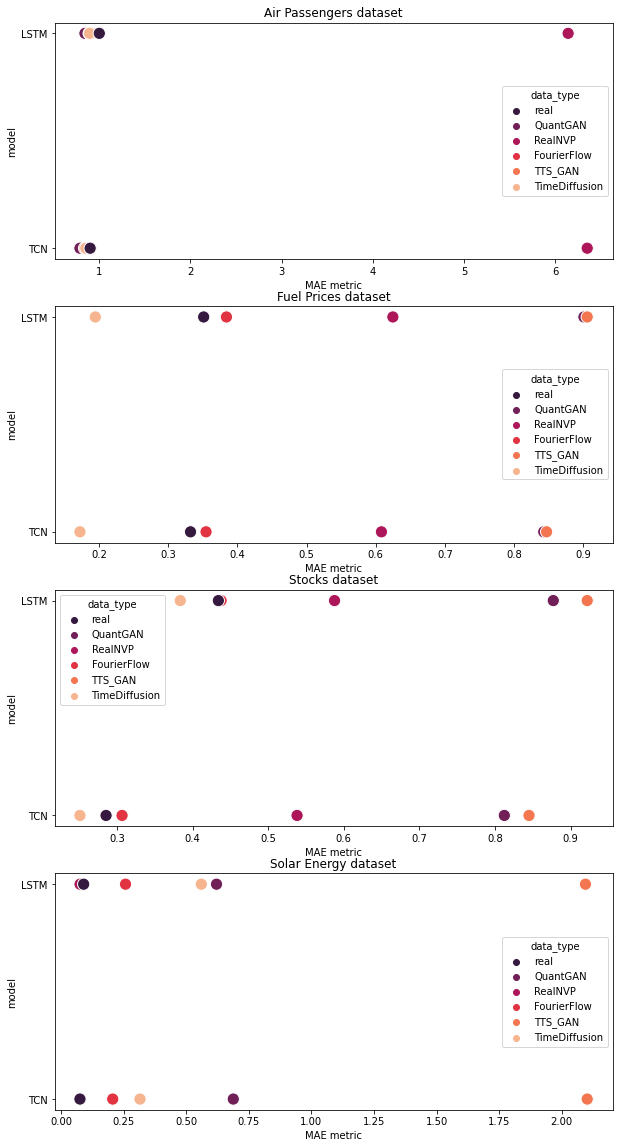

In [21]:
fig, axs = plt.subplots(4, figsize=(10, 20))
for i, dataset_name in enumerate(results_agg.dataset.unique()):
    loc_res = results_agg[results_agg.dataset == dataset_name]
    sns.scatterplot(x=loc_res["test"].rename("MAE metric"), y=loc_res["model"], hue=loc_res["results_type"].rename("data_type"),
     hue_order=("real", "QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN", "TimeDiffusion"), ax=axs[i], s=150, palette="rocket")
    axs[i].set_title({"hsm": "Stocks", "se": "Solar Energy", "fp": "Fuel Prices", "ap": "Air Passengers"}[dataset_name] + " dataset")

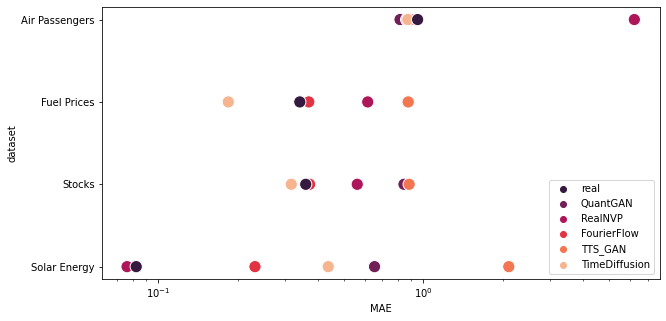

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
advanced_results_agg = results_agg.groupby(["dataset", "results_type"], as_index=False).agg(MAE=("test", "mean"))
sns.scatterplot(data=advanced_results_agg, x="MAE", y=advanced_results_agg["dataset"]\
    .replace({"hsm": "Stocks", "se": "Solar Energy", "fp": "Fuel Prices", "ap": "Air Passengers"}),\
    hue="results_type",\
    hue_order=("real", "QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN", "TimeDiffusion"), ax=ax, s=150, palette="rocket")
ax.legend(bbox_to_anchor=(0.99, 0.02), loc='lower right', borderaxespad=0)
plt.xscale("log")
plt.show()

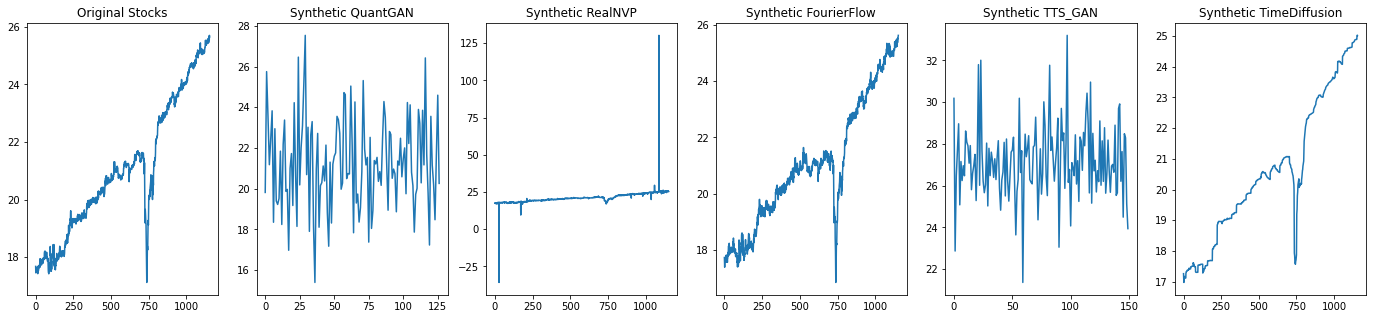

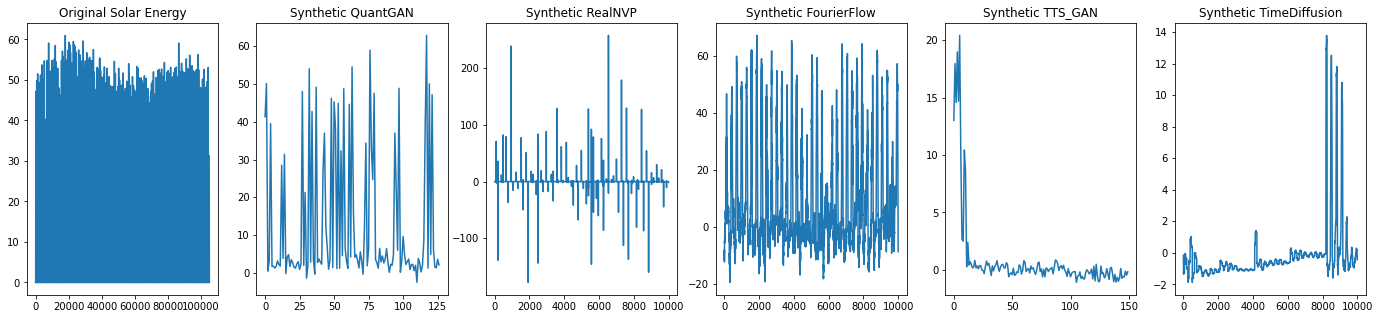

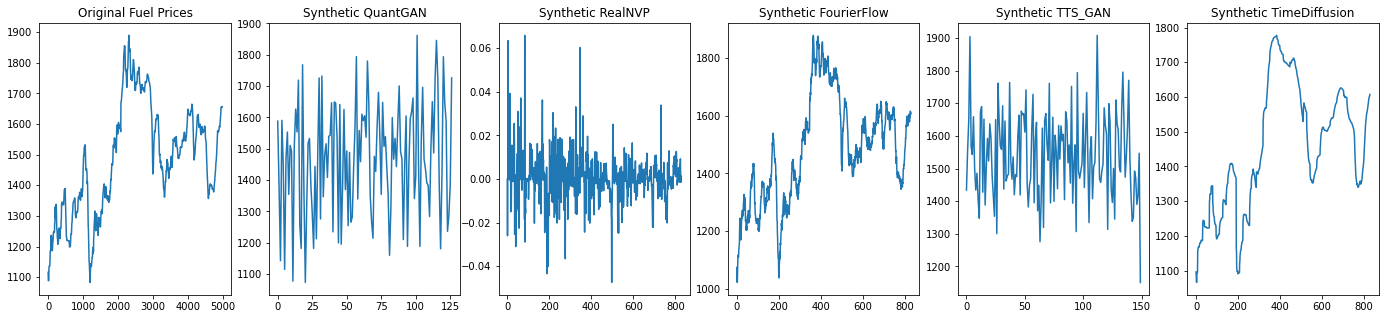

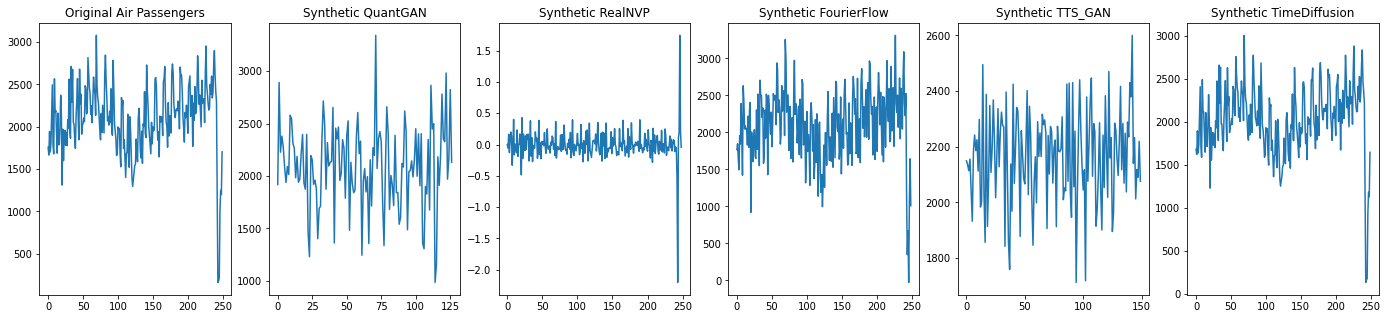

In [10]:
for dataset_name, dataset_dir, dataset_func in (
    ("Stocks", hsm_dataset_dir, get_hsm_dataset),
    ("Solar Energy", se_dataset_dir, get_solar_energy_dataset),
    ("Fuel Prices", fp_dataset_dir, get_fuel_prices_dataset),
    ("Air Passengers", ap_dataset_dir, get_passengers_dataset),    
):
    if dataset_name == "Stocks":
        time_series = next(dataset_func(dataset_dir, dataset_dir / "selected100.csv"))
    else:
        time_series = next(dataset_func(dataset_dir))

    fig, axs = plt.subplots(1, 6, figsize=(24, 5))
    axs[0].plot(time_series)
    axs[0].set_title(f"Original {dataset_name}")
    # axs[0].get_xaxis().set_visible(False)
    # axs[0].get_yaxis().set_visible(False)
    for i, model_name in zip(range(1, 6), ("QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN", "TimeDiffusion")):
        synth_time_series = np.load(dataset_dir / f"synthetic/{model_name}/selected0.npy")
        axs[i].plot(synth_time_series[0].flatten())
        axs[i].set_title(f"Synthetic {model_name}")
        # axs[i].get_xaxis().set_visible(False)
        # axs[i].get_yaxis().set_visible(False)
plt.show()

# Synthetic similarity results

In [11]:
results = []
for model in ("QuantGAN", "TTS_GAN", "RealNVP", "FourierFlow", "TimeDiffusion"):
    for dataset_name in ("hsm", "se", "fp", "ap"):
        df = pd.read_csv(results_dir / f"synth_{dataset_name}_sim_{model}.csv")
        results.append({"model": model, "dataset": dataset_name,
        "kl_div": df["kl_div"].mean(), "kstest_pval": df["kstest_pval"].mean()})
synth_sim_results = pd.DataFrame(results)
synth_sim_results

,model,dataset,kl_div,kstest_pval
0,QuantGAN,hsm,21.909068,1.083762e-03
1,QuantGAN,se,NaN,8.674951e-05
2,QuantGAN,fp,15.738731,8.957594e-02
3,QuantGAN,ap,4223.509422,9.772726e-02
4,TTS_GAN,hsm,11.696616,2.859402e-03
5,TTS_GAN,se,NaN,2.998212e-06
6,TTS_GAN,fp,13.111345,8.089774e-03
7,TTS_GAN,ap,2286.791598,2.092121e-02
8,RealNVP,hsm,0.669338,8.745733e-01
9,RealNVP,se,21.025093,0.000000e+00


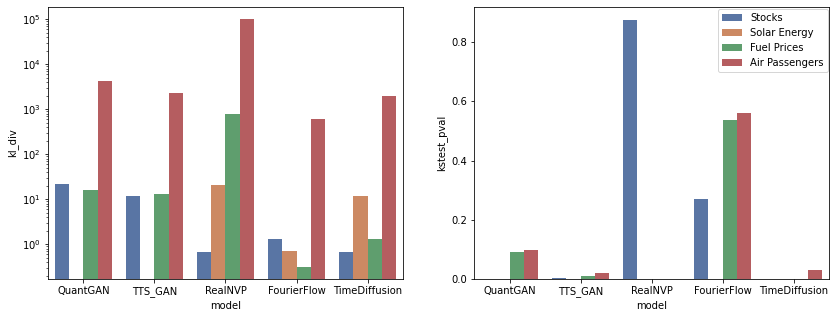

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for i, metric_name in enumerate(("kl_div", "kstest_pval")):
    sns.barplot(x=synth_sim_results["model"], y=synth_sim_results[metric_name], 
        hue=synth_sim_results["dataset"].replace({"hsm": "Stocks", "se": "Solar Energy", "fp": "Fuel Prices", "ap": "Air Passengers"}),\
             ax=axs[i], palette="deep")
axs[0].set_yscale("log")
axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.01, 1.01))
plt.show()

In [13]:
dfs = {}
for res_type in ("real", "QuantGAN", "TTS_GAN", "RealNVP", "FourierFlow", "TimeDiffusion"):
    for model in ("LSTM", "TCN"):#, "CBR"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            if res_type == "real":
                dfs[f"{res_type}_{model}_{dataset_name}"] = pd.read_csv(results_dir / f"{res_type}_{dataset_name}_{model}.csv")["test"]
            else:
                dfs[f"{res_type}_{model}_{dataset_name}"] = pd.read_csv(results_dir / f"synth_{res_type}_{dataset_name}_{model}.csv")["test"]
results = pd.DataFrame(dfs)
results

,real_LSTM_hsm,real_LSTM_se,real_LSTM_fp,real_LSTM_ap,real_TCN_hsm,real_TCN_se,real_TCN_fp,real_TCN_ap,QuantGAN_LSTM_hsm,QuantGAN_LSTM_se,...,FourierFlow_TCN_fp,FourierFlow_TCN_ap,TimeDiffusion_LSTM_hsm,TimeDiffusion_LSTM_se,TimeDiffusion_LSTM_fp,TimeDiffusion_LSTM_ap,TimeDiffusion_TCN_hsm,TimeDiffusion_TCN_se,TimeDiffusion_TCN_fp,TimeDiffusion_TCN_ap
0,0.352968,0.101048,0.202559,0.795698,0.260205,0.094826,0.166383,0.723236,0.899521,0.706591,...,0.202846,0.711581,0.346336,2.241899,0.109702,0.821831,0.154550,0.931396,0.111773,0.776452
1,0.168099,0.109768,0.143776,0.625052,0.152844,0.087528,0.156278,0.601431,0.818553,0.537700,...,0.168418,0.628996,0.159069,0.847574,0.142581,0.627038,0.114476,0.473090,0.149488,0.644631
2,1.425858,0.081412,0.268309,0.082674,0.939176,0.065697,0.208905,0.080697,0.858767,0.588449,...,0.216392,0.277708,2.024961,0.215754,0.272316,0.099079,0.891205,0.142050,0.235973,0.100103
3,0.139445,0.082459,0.164236,0.464227,0.068642,0.071523,0.138380,0.504273,0.857949,0.528344,...,0.173286,0.499886,0.076775,0.212273,0.226050,0.443841,0.054790,0.178477,0.181473,0.414670
4,0.283939,0.080015,0.229799,0.884233,0.137041,0.067907,0.233753,0.944198,0.940779,0.675989,...,0.244187,1.016143,0.449910,0.184263,0.245965,0.287803,0.134459,0.134539,0.209660,0.347012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.311294,NaN,NaN,NaN,0.252606,NaN,NaN,NaN,1.005319,NaN,...,NaN,NaN,0.274397,NaN,NaN,NaN,0.225888,NaN,NaN,NaN
96,0.228035,NaN,NaN,NaN,0.247496,NaN,NaN,NaN,0.964678,NaN,...,NaN,NaN,0.316254,NaN,NaN,NaN,0.209485,NaN,NaN,NaN
97,0.502270,NaN,NaN,NaN,0.060227,NaN,NaN,NaN,0.897746,NaN,...,NaN,NaN,0.176836,NaN,NaN,NaN,0.052037,NaN,NaN,NaN
98,1.980303,NaN,NaN,NaN,0.266872,NaN,NaN,NaN,0.928570,NaN,...,NaN,NaN,1.409883,NaN,NaN,NaN,0.258687,NaN,NaN,NaN


In [14]:
corrs = []
ds_lens = {"hsm": 100, "se": 10, "fp": 8, "ap": 50}
for model in ("LSTM", "TCN"):#, "CBR"):
    for res_type in ("QuantGAN", "TTS_GAN", "RealNVP", "FourierFlow", "TimeDiffusion"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            # correlation
            res = np.corrcoef([results[f"real_{model}_{dataset_name}"][:ds_lens[dataset_name]],
                results[f"{res_type}_{model}_{dataset_name}"][:ds_lens[dataset_name]]])[0][1]
            z = 0.5 * np.log((1 + res) / (1 - res))
            SE =  1 / (ds_lens[dataset_name] - 3) ** 0.5
            zl, zh = z - 1.96 * SE, z + 1.96 * SE
            lb, hb = ((np.e ** (2 * zl) - 1) / (np.e ** (2 * zl) + 1), (np.e ** (2 * zh) - 1) / (np.e ** (2 * zh) + 1))
            corrs.append({"model": model, "synth_model": res_type, "dataset": dataset_name, "correlation": res,\
                "low_bound": lb, "high_bound": hb})
corrs = pd.DataFrame(corrs)
corrs

,model,synth_model,dataset,correlation,low_bound,high_bound
0,LSTM,QuantGAN,hsm,0.069925,-0.128258,0.262738
1,LSTM,QuantGAN,se,-0.374023,-0.812351,0.334350
2,LSTM,QuantGAN,fp,-0.398002,-0.861159,0.426218
3,LSTM,QuantGAN,ap,-0.125052,-0.389835,0.158829
4,LSTM,TTS_GAN,hsm,-0.071949,-0.264630,0.126257
5,LSTM,TTS_GAN,se,-0.084695,-0.678165,0.575636
6,LSTM,TTS_GAN,fp,-0.318438,-0.835610,0.497991
7,LSTM,TTS_GAN,ap,-0.109112,-0.376044,0.174541
8,LSTM,RealNVP,hsm,0.739821,0.635791,0.817453
9,LSTM,RealNVP,se,0.072777,-0.583600,0.671635


In [15]:
corrs_agg = corrs.groupby(["dataset", "synth_model"], as_index=False).mean()
corrs_agg

C:\Users\Владислав\AppData\Local\Temp/ipykernel_15420/2987291452.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  corrs_agg = corrs.groupby(["dataset", "synth_model"], as_index=False).mean()


,dataset,synth_model,correlation,low_bound,high_bound
0,ap,FourierFlow,0.875537,0.789785,0.927745
1,ap,QuantGAN,-0.151506,-0.412305,0.132227
2,ap,RealNVP,0.165381,-0.118422,0.424205
3,ap,TTS_GAN,-0.130265,-0.394217,0.153530
4,ap,TimeDiffusion,0.859314,0.764146,0.917947
5,fp,FourierFlow,0.997650,0.986520,0.999592
6,fp,QuantGAN,-0.486970,-0.886039,0.321451
7,fp,RealNVP,0.797682,0.212785,0.961743
8,fp,TTS_GAN,-0.156580,-0.768812,0.602659
9,fp,TimeDiffusion,-0.279590,-0.822176,0.529093


<AxesSubplot:xlabel='synth_model', ylabel='correlation'>

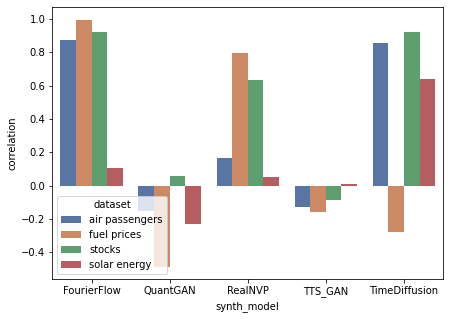

In [16]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x=corrs_agg["synth_model"], y=corrs_agg["correlation"],\
    hue=corrs_agg["dataset"].replace({"se": "solar energy", "hsm": "stocks", "fp": "fuel prices", "ap": "air passengers"}), \
        ax=ax, palette="deep")

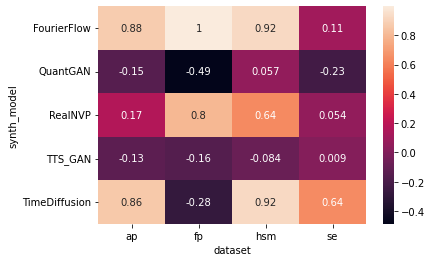

In [17]:
sns.heatmap(
    corrs_agg.pivot_table(index="synth_model", columns="dataset", values="correlation", aggfunc=np.mean),
    annot=True
)
plt.show()

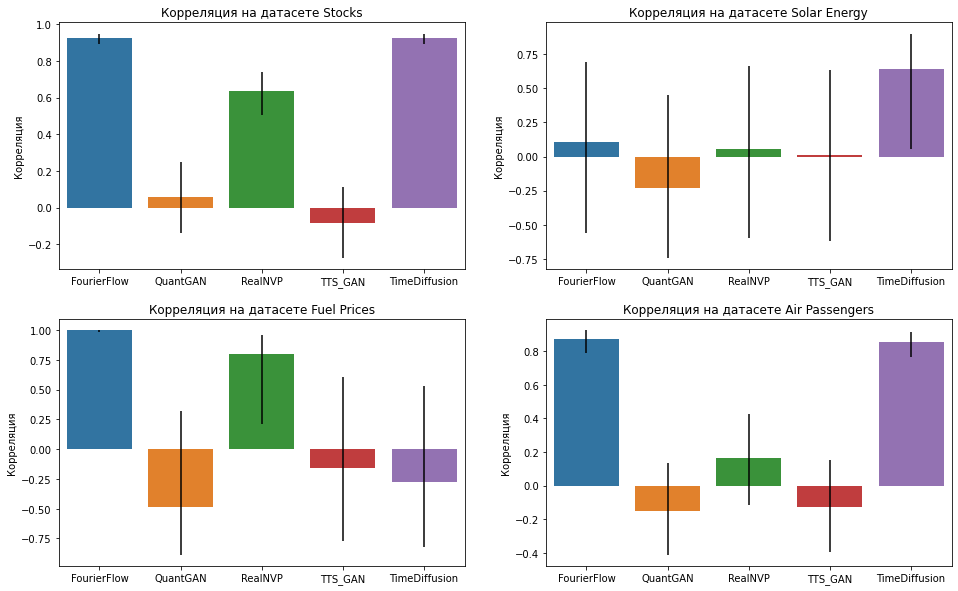

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
for i, dsname in enumerate(("hsm", "se", "fp", "ap")):
    loc_data = corrs_agg[corrs_agg.dataset == dsname]
    sns.barplot(data=loc_data, x="synth_model", y="correlation",\
        yerr=(loc_data["correlation"] - loc_data["low_bound"], loc_data["high_bound"] - loc_data["correlation"]), ax=axs[i // 2][i % 2])
    axs[i // 2][i % 2].set_title("Корреляция на датасете " + {"se": "Solar Energy", "hsm": "Stocks", "fp": "Fuel Prices", "ap": "Air Passengers"}[dsname])
    axs[i // 2][i % 2].set_xlabel("")
    axs[i // 2][i % 2].set_ylabel("Корреляция")

Deviation

In [19]:
devs = []  # deviation
ds_lens = {"hsm": 100, "se": 10, "fp": 8, "ap": 50}
for model in ("LSTM", "TCN"):#, "CBR"):
    for res_type in ("QuantGAN", "TTS_GAN", "RealNVP", "FourierFlow", "TimeDiffusion"):
        for dataset_name in ("hsm", "se", "fp", "ap"):
            # deviation
            dev = np.mean(np.abs(results[f"{res_type}_{model}_{dataset_name}"][:ds_lens[dataset_name]] /\
                results[f"real_{model}_{dataset_name}"][:ds_lens[dataset_name]] - 1)) * 100
            devs.append({"model": model, "synth_model": res_type, "dataset": dataset_name, "deviation": dev,})
devs = pd.DataFrame(devs)
devs

,model,synth_model,dataset,deviation
0,LSTM,QuantGAN,hsm,330.209970
1,LSTM,QuantGAN,se,607.995278
2,LSTM,QuantGAN,fp,265.912175
3,LSTM,QuantGAN,ap,51.917864
4,LSTM,TTS_GAN,hsm,373.759342
5,LSTM,TTS_GAN,se,2280.090110
6,LSTM,TTS_GAN,fp,266.651272
7,LSTM,TTS_GAN,ap,55.266286
8,LSTM,RealNVP,hsm,53.855794
9,LSTM,RealNVP,se,19.011549


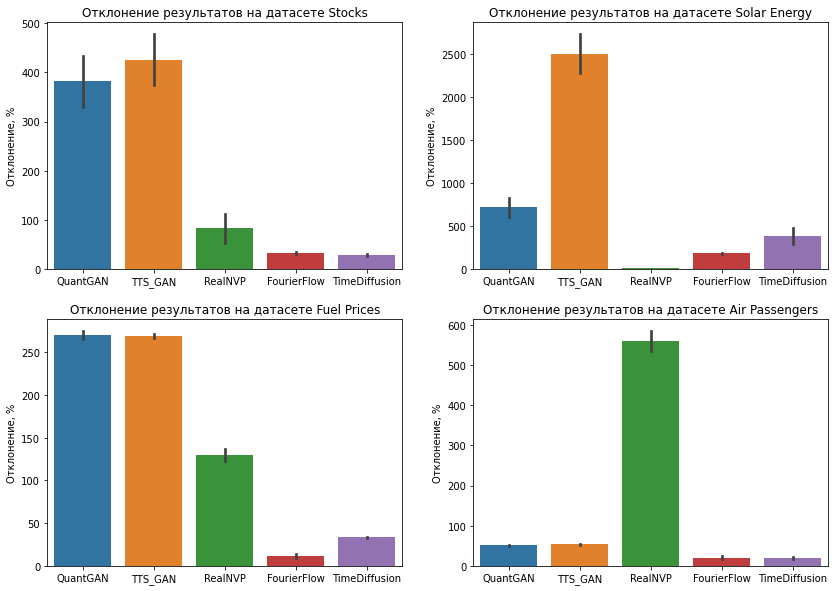

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
ds_name_extension = {"se": "Solar Energy", "hsm": "Stocks", "fp": "Fuel Prices", "ap": "Air Passengers"}
for i, dataset in enumerate(("hsm", "se", "fp", "ap")):
    sns.barplot(data=devs[devs.dataset == dataset], x="synth_model", y="deviation", ax=axs[i // 2][i % 2])
    axs[i // 2][i % 2].set_title(f"Отклонение результатов на датасете {ds_name_extension[dataset]}")
    axs[i // 2][i % 2].set_ylabel("Отклонение, %")
    axs[i // 2][i % 2].set_xlabel("")